In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from yass.config import Config
from yass.neuralnet import NeuralNetDetector, NeuralNetTriage, conv2d, conv2d_VALID
from yass.augmentedSpikes import AugmentedSpikes
from yass.preprocessing import Preprocessor
from yass.geometry import (n_steps_neigh_channels,
                                  order_channels_by_distance)
from yass.preprocess.filter import butterworth

In [3]:
import os
import numpy as np
import tensorflow as tf
import progressbar
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
cfg = Config.from_yaml('../peter_config.yaml')
n_observations = 6000000

In [5]:
# load ground truth
# make spikeTrain
import scipy.io
kk = scipy.io.loadmat(os.path.join(cfg.root, 'groundtruth_ej49_data1_set1.mat'))
L_gt = kk['L_gt']-1
spt_gt = kk['spt_gt']
spikeTrain = np.concatenate((spt_gt, L_gt),axis=1)

In [6]:
# load class for making augmented spikes
asp = AugmentedSpikes(cfg,spikeTrain)

In [7]:
# get parameters
R = asp.config.spikeSize*2+1
N = 50000

In [8]:
def get_noise_data(asp, N, R):
    spatial_SIG, temporal_SIG = asp.determineNoiseCov(R,1)
    C = spatial_SIG.shape[0]
    # get noise
    noise = np.random.normal(size=(N,R,C))
    for c in range(noise.shape[2]):
        noise[:,:,c] = np.matmul(noise[:,:,c],temporal_SIG)

        reshaped_noise = np.reshape(noise,(-1,noise.shape[2]))
    noise = np.reshape(np.matmul(reshaped_noise,spatial_SIG),[N,R,C])

    return noise


In [9]:
def get_noise_data_part1(self, R, th):     
    D = 1
    pp = Preprocessor(self.config)

    batch_size = self.config.batch_size
    BUFF = self.config.BUFF
    nBatches = self.config.nBatches
    nPortion = self.config.nPortion
    residual = self.config.residual

    # get recording in the middle
    pp.openFile()
    i = np.ceil(nBatches/2)

    # reading data
    if nBatches ==1:
        rec = pp.load(0, batch_size)

    elif i == 0:
        rec = pp.load(i*batch_size, batch_size+BUFF)

    elif i < nBatches-1:
        rec = pp.load(i*batch_size-BUFF, batch_size+2*BUFF)

    elif residual==0:
        rec = pp.load(i*batch_size-BUFF, batch_size+BUFF)

    else:
        rec = pp.load(i*batch_size-BUFF, residual+BUFF)

    # filter recording
    if pp.config.doFilter == 1:
        rec = butterworth(rec, self.config.filterLow,
                          self.config.filterHighFactor,
                          self.config.filterOrder,
                          self.config.srate)

    # standardize recording
    small_t = np.min((int(pp.config.srate*5), n_observations))
    mid_T = int(np.ceil(rec.shape[0]/2))
    rec_temp = rec[np.arange(mid_T-small_t,mid_T+small_t)]
    sd = np.median(np.abs(rec),0)/0.6745;
    rec = np.divide(rec,sd)

    pp.closeFile()
    T,C = rec.shape
    idxNoise = np.zeros((T,C))

    for c in range(C):
        idx_temp = np.where(np.abs(rec[:,c]) > th)[0]
        for j in range(-(2*R),(2*R)+1):
            idx_temp2 = idx_temp +j
            idx_temp2 = idx_temp2[np.logical_and(idx_temp2 >=0, idx_temp2 <T)]
            rec[idx_temp2,c] = np.nan
        idxNoise_temp = (rec[:,c] == rec[:,c])
        rec[:,c] = rec[:,c]/np.nanstd(rec[:,c])
        idxNoise[~idxNoise_temp,c] = 1

    return rec, idxNoise

In [10]:
def get_noise_data_part2(rec,idxNoise, R, neighbor):
   
    T,C = rec.shape
    
    idxNoise_convolved = np.zeros((T,C))
    for c in range(C):
        idxNoise_convolved[:,c] = np.convolve(idxNoise[:,c], np.ones(R),'same')
        
    count = 0
    nneigh = np.max(np.sum(neighbor,0))
    c_candidate = np.where(np.sum(neighbor, 0) == nneigh)[0]
    R2 = int((R-1)/2)
    
    noise = np.zeros((1000000,R,nneigh))
    for c in range(c_candidate.shape[0]):
        cc = c_candidate[c]
        print('channel: '+ str(cc) + ', ' +str(count)+' spikes obtained upto now!')
        ch_idx = neighbor[cc]
        temp = np.sum(idxNoise_convolved[:,ch_idx],1)
        t_loc = np.where(temp == 0)[0]
        rec_temp = rec[:,ch_idx]
        for tt in t_loc:
            noise[count] = rec_temp[(tt-R2):(tt+R2+1)]
            count += 1

    noise = noise[:count]
    
    return noise

In [11]:
#noise = get_noise_data(asp, 50000, R)


In [12]:
rec, idxNoise = get_noise_data_part1(asp, 51, 3)
noise = get_noise_data_part2(rec, idxNoise, 51, asp.config.neighChannels)

/home/eduardo/miniconda3/envs/noise/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: class Preprocessor is deprecated: (Use function in preprocess module, see examples/preprocess.py)
  This is separate from the ipykernel package so we can avoid doing imports until


channel: 0, 0 spikes obtained upto now!
channel: 1, 29672 spikes obtained upto now!
channel: 2, 49578 spikes obtained upto now!
channel: 3, 98871 spikes obtained upto now!
channel: 4, 114184 spikes obtained upto now!
channel: 5, 142821 spikes obtained upto now!
channel: 6, 150027 spikes obtained upto now!
channel: 7, 161938 spikes obtained upto now!
channel: 8, 179563 spikes obtained upto now!
channel: 9, 229930 spikes obtained upto now!
channel: 10, 234690 spikes obtained upto now!
channel: 11, 265178 spikes obtained upto now!
channel: 12, 294912 spikes obtained upto now!
channel: 13, 322723 spikes obtained upto now!
channel: 14, 338681 spikes obtained upto now!
channel: 15, 388225 spikes obtained upto now!
channel: 16, 405261 spikes obtained upto now!
channel: 17, 443379 spikes obtained upto now!
channel: 18, 453577 spikes obtained upto now!
channel: 19, 477736 spikes obtained upto now!
channel: 20, 505469 spikes obtained upto now!
channel: 21, 511473 spikes obtained upto now!
channe

In [13]:
# load nueral net
nnd = NeuralNetDetector(cfg)
nnt = NeuralNetTriage(cfg)

In [14]:
def run_detector(self, x_train, loc_ckpt):
    # get parameters
    ndata, T, C = x_train.shape
    R1, R2, R3 = self.config.neural_network['nnFilterSize']
    K1, K2, K3 = self.config.neural_network['nnNFilters']

    x_tf = tf.placeholder("float", [ndata, T, C])

    layer1 = tf.nn.relu( conv2d_VALID( tf.expand_dims(x_tf,-1), self.W1 ) + self.b1 )
    layer11 = tf.nn.relu( conv2d( layer1, self.W11 ) + self.b11 )
    o_layer = tf.squeeze( conv2d_VALID( layer11, self.W2 ) + self.b2 )
    
    with tf.Session() as sess:
        self.saver.restore(sess, loc_ckpt)
        idx = sess.run(o_layer, feed_dict={x_tf: x_train}) > 0

    return idx

In [16]:
noise_temp = noise[:,int((noise.shape[1]-1)/2-15):int((noise.shape[1]-1)/2+16),:]
idx = run_detector(nnd, noise_temp, os.path.join(cfg.root, cfg.neural_network['nnFilename']))

In [17]:
idx.shape

(680776,)

In [26]:
noise.shape

(680776, 51, 7)

In [18]:
np.where(idx)[0][1:20]

array([1090, 1091, 1574, 1575, 1576, 1983, 1984, 2116, 2514, 2515, 2815,
       2816, 2981, 2982, 2983, 3192, 3589, 3590, 3591])

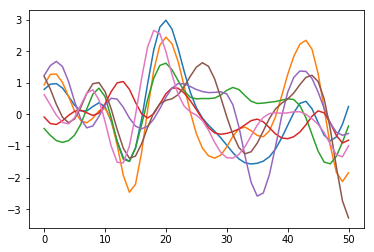

In [19]:
plt.plot(noise[3590])
plt.show()

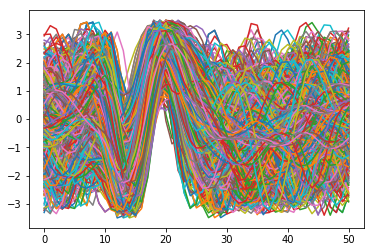

In [20]:
plt.plot(noise[idx,:,0].T)
plt.show()

In [21]:
proj = nnd.load_w_ae()

In [22]:
ch_idx = np.array([0, 1, 3, np.nan, np.nan])

In [23]:
noise[:,:,ch_idx]

IndexError: arrays used as indices must be of integer (or boolean) type

In [28]:
noise_temp = noise[:,int((noise.shape[1]-1)/2-15):int((noise.shape[1]-1)/2+16),:]
score = np.zeros((noise_temp.shape[0], proj.shape[1], noise_temp.shape[2]))
for c in range(noise_temp.shape[2]):
    score[:,:,c] = np.matmul(noise_temp[:,:,0],proj)
    

In [29]:
from yass.MFM import spikesort

In [31]:
score

(680776, 3, 7)

In [34]:
np.save('/ssd/data/eduardo/score', score)

In [227]:
L = spikesort(score, np.ones((score.shape[0],score.shape[2])), np.arange(score.shape[0]), cfg)

MemoryError: 

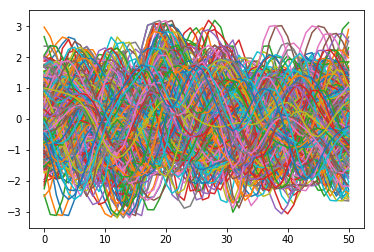

In [173]:
plt.plot(noise2[idx2,:,0].T)
plt.show()

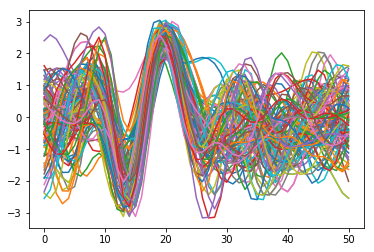

In [184]:
plt.plot(noise3[idx3,:,0].T)
plt.show()

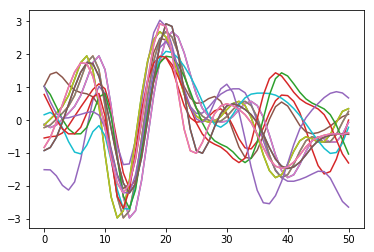

In [183]:
plt.plot(noise4[idx4,:,0].T)
plt.show()